In [21]:
# python libraries
import os
import sys
import dataclasses
from datetime import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
import torchvision
from torch import nn
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchinfo
except:
    print(f"[INFO] Installing the torchinfo")
    %pip install torchinfo
    import torchinfo

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

[INFO] Installing the torchsummary
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Network in Network

In [4]:
@dataclass(eq=False)
class NiN(helper.Classifier):
    lr:int = 0.01
    num_classes:int = 10

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.nin_block(96,kernel=11,stride=4,padding=0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(256,kernel=5,stride=1,padding=2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(384,kernel=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(self.num_classes,kernel=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )


    @staticmethod
    def nin_block(out_channels,kernel,stride,padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=kernel,stride=stride,padding=padding),nn.ReLU(),
            # this two layer will do job of FC , this will  increase the non linearity.
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU(),
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU()          
        )
    @staticmethod
    def init_nin(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [5]:
NiN().layer_summary((1,1,224,224))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential      output shape :(1, 96, 54, 54)
MaxPool2d       output shape :(1, 96, 26, 26)
Sequential      output shape :(1, 256, 26, 26)
MaxPool2d       output shape :(1, 256, 12, 12)
Sequential      output shape :(1, 384, 12, 12)
MaxPool2d       output shape :(1, 384, 5, 5)
Dropout         output shape :(1, 384, 5, 5)
Sequential      output shape :(1, 10, 5, 5)
AdaptiveAvgPool2d output shape :(1, 10, 1, 1)
Flatten         output shape :(1, 10)


In [22]:
torchinfo.summary(NiN(),input_size=(1,224,224)  ,  col_width=14,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type (var_name))                  Kernel Shape   Output Shape   Param #        Mult-Adds
NiN (NiN)                                --             [10, 1]        --             --
├─Sequential (net)                       --             [10, 1]        --             --
│    └─Sequential (0)                    --             [96, 54, 54]   --             --
│    │    └─Conv2d (0)                   [11, 11]       [96, 54, 54]   11,712         60,715,008
│    │    └─ReLU (1)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (2)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (3)                     --             [96, 54, 54]   --             --
│    │    └─Conv2d (4)                   [1, 1]         [96, 54, 54]   9,312          48,273,408
│    │    └─ReLU (5)                     --             [96, 54, 54]   --             --
│    └─MaxPool2d (1)                     3              [96, 26, 26]   --      

The total parameter size is reduce compare to pervious architecture like AlexNet ,VGG , since they had the FC layer 

# Training

In [7]:
model = NiN(lr=0.01)
data = helper.FashionMNIST(batch_size=128,resize=(224,224))
model.apply_init([(next(iter(data.train_dataloader())))[0]],model.init_nin)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

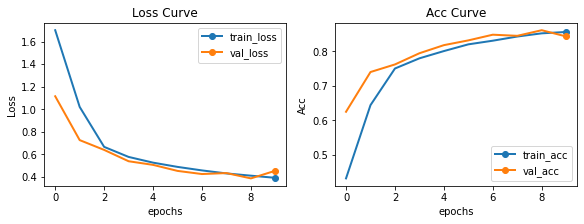

[Info] Saving the model at /content/drive/Othercomputers/My PC/drive/models/2023-02-04/NiN-12:16:43.pth


In [8]:
trainer =helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)
trainer.fit(model,data)